In [1]:
# Import Libs

import sys
sys.path.append('/Users/rohit.jishtu/Documents/My Projects/GIt Bkp/Projects/ML Projects/Project 5 - Regression Problem')
print(sys.path)

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from Functions import *

['/Users/rohit.jishtu/Documents/GitHub/Projects/DL Projects/NLP/Amazon Food Review', '/opt/homebrew/Cellar/python@3.10/3.10.13/Frameworks/Python.framework/Versions/3.10/lib/python310.zip', '/opt/homebrew/Cellar/python@3.10/3.10.13/Frameworks/Python.framework/Versions/3.10/lib/python3.10', '/opt/homebrew/Cellar/python@3.10/3.10.13/Frameworks/Python.framework/Versions/3.10/lib/python3.10/lib-dynload', '', '/Users/rohit.jishtu/Library/Python/3.10/lib/python/site-packages', '/opt/homebrew/lib/python3.10/site-packages', '/Users/rohit.jishtu/Documents/My Projects/GIt Bkp/Projects/ML Projects/Project 5 - Regression Problem']


In [2]:
# # Creating connection to the database 
# you can find this data set at Kaggle serach with Amazon food review Database 
# https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews


conn=sqlite3.connect('/Users/rohit.jishtu/Documents/My Projects/GIt Bkp/Projects/Deep Learning/NLP/Amazon Food Review/amazon_reviews/database.sqlite')

In [3]:
SourceDf= pd.read_sql("select * from reviews",conn)
SourceDf.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Step1: Labeling and Target identification

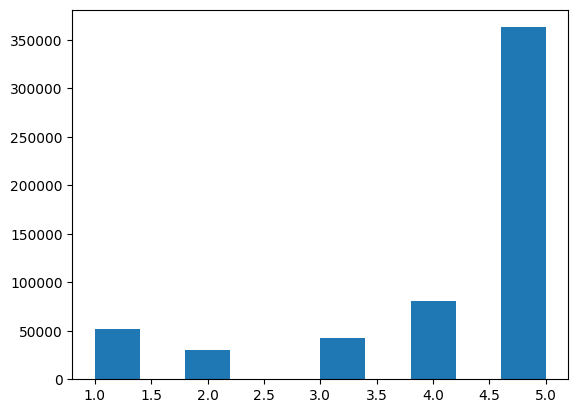

In [4]:
plt.hist(SourceDf['Score'])
SourceDf['Score'].value_counts().sort_index()

# Remove neutral Score 3 from source 
SourceDf=SourceDf[SourceDf['Score']!=3]

In [5]:
SourceDf['Rating']=SourceDf['Score'].apply(lambda x: 'Positive' if x >=4 else 'Negative')
SourceDf['Rating'].value_counts()
# plt.hist(SourceDf['Rating'])

Positive    443777
Negative     82037
Name: Rating, dtype: int64

In [6]:
SourceDf[(SourceDf['Rating']=='Negative') & (SourceDf['ProfileName']=='Jeanne Tomassi')]


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Rating
254739,254740,B007PA32L2,A2FJ3HQ2RJAIYH,Jeanne Tomassi,7,7,1,1347321600,What happened to Pumpkin Spice?,"[[ASIIN:B007PA32L2 Green Mountain Coffee, Pump...",Negative
434217,434218,B003Z6ZGZU,A2FJ3HQ2RJAIYH,Jeanne Tomassi,7,7,1,1347321600,What happened to Pumpkin Spice?,"[[ASIIN:B007PA32L2 Green Mountain Coffee, Pump...",Negative


# Step 2 : Data Cleaning

In [7]:
SourceDf.shape

(525814, 11)

In [8]:
# [[ASIIN:B007PA32L2 Green Mountain Coffee, Pumpkin Spice K-Cup packs for Keurig Brewers, 
#   50 count]]<br />I am so very disappointed in the lack of flavor and aroma 
# in the new packaging of the Pumpkin spice K-cup packs.<br />The packaging is different and it says "light roast".  
# This is definately not the same coffee that I've enjoyed so much over the last 2 years. 
# I really hope they bring back the original flavor!!! What a shame!!!

In [9]:
# Finding the same review by a user and seeing of they are repeating 
Groupdata=SourceDf.groupby(['UserId','Text','ProductId'])['Text'].agg(['count']).reset_index().sort_values(by=['count'],ascending=False)

In [10]:
SourceDf = SourceDf.drop_duplicates(subset=['UserId','Text','ProductId'],keep='first')

In [11]:
# (525814, 11) Before RemovinG Duplicates 
# (524587, 11) After RemovinG Duplicates 
SourceDf.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text', 'Rating'],
      dtype='object')

In [12]:
numeric_stats=CalBasicStats(SourceDf,'numeric')
NONnumeric_stats=CalBasicStats(SourceDf,'nonnumeric')

# The columns are high in variance skewed towards zero or 1 

# plt.hist(SourceDf['HelpfulnessNumerator'],bins=5)
# plt.hist(SourceDf['HelpfulnessDenominator'],bins=5)

Positive    0.844224
Negative    0.155776
Name: Rating, dtype: float64


Text(0.5, 1.0, 'Target Distribution')

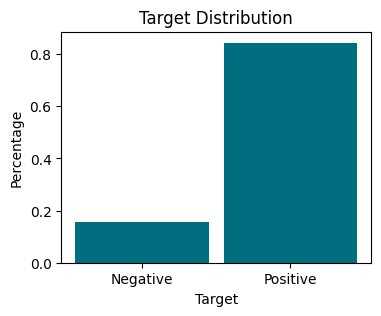

In [13]:

Targetdf=SourceDf.groupby(['Rating'])['Id'].count().reset_index()
Targetdf['RatingPercentage'] = Targetdf['Id']/sum(Targetdf['Id'])
print(SourceDf['Rating'].value_counts()/SourceDf.shape[0])


# # Plotting target
plt.figure(figsize=(4, 3))
Targetdf['Rating']=Targetdf['Rating'].astype(str)
plt.bar( Targetdf['Rating'], Targetdf['RatingPercentage'],color='#006E7F', width=0.9, align='center') 

plt.xlabel('Target')
plt.ylabel('Percentage')
plt.title('Target Distribution')


In [14]:
Targetdf

,Rating,Id,RatingPercentage
0,Negative,81718,0.155776
1,Positive,442869,0.844224


# Step 3: Text Preprocessing 

In [15]:
# Text Cleaning 
# Tokensisation 
# Stop word removal 
# Stemming  
# lemmetisation 


In [16]:
import nltk
import re 
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords 
from nltk.stem import SnowballStemmer , PorterStemmer 
from nltk.stem.wordnet import WordNetLemmatizer

In [17]:
text="""- Excellent cuts of meat with no tendons.<br />- Very tasty. Just the right mix of spices.<br />- No added MSG 
and no added sugar!<br />- Convenient small snack-size bags.<br /><br />The best jerky I've ever encountered.
"""

In [18]:
def Preprocessing(inputdata):

    # Activity 1 : Text Cleaning using regex 
    clean_data1 = re.sub(r'<br.\s*/?>|-|\n', '', inputdata)
    clean_text = re.sub(r'[^\w\s]', '', clean_data1)
    # print(f"{clean_text=}")
    # Activity 2 : Tokenise
    token_list=[]
    for word in str.split(clean_text,' '):
        if len(word)>0:
            word=word.lower()
            token_list.append(word)
        
    # print(f"{token_list=}")
    
    # Activity 3 : StopWords 
    stop_words_dict=stopwords.words("english")
    custome_stopwords =['abc','ahh','aahh']
    stop_words=stop_words_dict+custome_stopwords
    stop_word_list=[word for word in token_list if word not in stop_words]
    # print(f"{stop_word_list=}")
    
    # # Activity 4.1 : Stemmer
    # snow_stem=SnowballStemmer("english")
    # port_stem=PorterStemmer()

    # poststem_list=[]
    # for word in stop_word_list:
    #     newword=snow_stem.stem(word)
    #     # newword2=port_stem.stem(word)
    #     print(f"{word=}{newword=}")
    #     poststem_list.append(newword)

    # Activity 4.2 : lemmetizer (emphasis on language)

    word_lem = WordNetLemmatizer()
    postlem_list=[]
    for word in stop_word_list:
        newword=word_lem.lemmatize(word)
        # newword2=port_stem.stem(word)
        # print(f"{word=}{newword=}")
        postlem_list.append(newword)
    textreturn = ' '.join(postlem_list)
    return textreturn
    
    # stop_words=stopwrods.
 

In [19]:
# cleanedtext= Preprocessing(text)
# word_tokenize(clean_text_1)

In [20]:
# Applying All preprocess to All the text column in data frame

SourceDf['Processed_Text']=  SourceDf['Text'].apply(lambda x : Preprocessing(x))

# Step 4 : Bag of Words 

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

In [23]:
CountVec=CountVectorizer(max_features=1000)
dtm_sparse_matrix1 =CountVec.fit_transform(SourceDf['Processed_Text'])

dtm_sparse_matrix1.toarray()

NameError: name 'dtm_sparse_matrix' is not defined

In [198]:
CountVec.get_feature_names_out()[1:100]

array(['100', '12', '13', '14', '15', '16', '20', '24', '25', '30', '50',
       'able', 'absolutely', 'acid', 'across', 'actual', 'actually',
       'add', 'added', 'adding', 'addition', 'adult', 'afternoon',
       'aftertaste', 'ago', 'agree', 'allergy', 'almond', 'almost',
       'alone', 'along', 'already', 'also', 'alternative', 'although',
       'always', 'amazing', 'amazon', 'amazoncom', 'american', 'amount',
       'animal', 'another', 'anymore', 'anyone', 'anything', 'anyway',
       'anywhere', 'apple', 'area', 'arent', 'aroma', 'around', 'arrived',
       'artificial', 'ask', 'asked', 'ate', 'available', 'avoid', 'away',
       'awesome', 'awful', 'baby', 'back', 'bad', 'bag', 'baked',
       'baking', 'balance', 'ball', 'banana', 'bar', 'based', 'basically',
       'batch', 'bbq', 'bean', 'beat', 'become', 'beef', 'believe',
       'benefit', 'berry', 'best', 'better', 'beverage', 'big', 'biscuit',
       'bit', 'bite', 'bitter', 'black', 'bland', 'blend', 'blood',
      

# Step 5 :Additional Dimension using BI Grams and Tri Grams

In [28]:
CountVec=CountVectorizer(ngram_range=(1,3),min_df=0.1,max_df=0.99)
dtm_sparse_matrix2=CountVec.fit_transform(SourceDf['Processed_Text'])

# 1% rare words removed 
# 99% percent repetaing terms removed 

In [25]:
CountVec.get_feature_names_out()

array(['also', 'amazon', 'best', 'better', 'buy', 'coffee', 'dont',
       'even', 'find', 'flavor', 'food', 'get', 'good', 'great', 'im',
       'like', 'little', 'love', 'make', 'much', 'one', 'price',
       'product', 'really', 'store', 'taste', 'time', 'tried', 'try',
       'use', 'well', 'would'], dtype=object)

# Step  6 : TF - IDF  Matrix 

In [29]:
# How is this Diefferent from BOQ

# TF = Occurance of terms in document  / Total terms in document 
# IDF : How rare is the word wrt to total Corpus 

# IDF = log(base10) (Total Documents in corpus / Occurance of the term in documents)
# IDf for more frequent term is zero , less frequnent have some values 

# TF-IDF= tf * idf  

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [33]:
tfidf=TfidfVectorizer(ngram_range=(1,2),min_df=0.005)
tfidf_matrix = tfidf.fit_transform(SourceDf['Processed_Text'])


tfidf_matrix

<524587x1243 sparse matrix of type '<class 'numpy.float64'>'
	with 13281227 stored elements in Compressed Sparse Row format>

In [38]:
CountVec.get_feature_names_out()

array(['also', 'amazon', 'best', 'better', 'buy', 'coffee', 'dont',
       'even', 'find', 'flavor', 'food', 'get', 'good', 'great', 'im',
       'like', 'little', 'love', 'make', 'much', 'one', 'price',
       'product', 'really', 'store', 'taste', 'time', 'tried', 'try',
       'use', 'well', 'would'], dtype=object)

# Step 7 :Model Building  - SVM Classifier 

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix


In [43]:
SourceDf['Target']=SourceDf['Rating'].map({'Positive':1,'Negative':0})

In [51]:
X=SourceDf['Processed_Text']
Y=SourceDf['Target']

In [55]:
X_train,X_test,Y_train,y_test=train_test_split(X,Y,test_size=0.30,random_state=12)
X_train.shape,
X_test.shape
Y_train.shape
y_test.shape

(157377,)

In [59]:
# We will use tfidf to transform data to tf IDF 
X_Train_tfidf=tfidf.fit_transform(X_train)
X_Test_tfidf= tfidf.transform(X_test)

In [57]:
SVM_classifier = LinearSVC(C=1,penalty='l1',dual=False,random_state=12)

In [60]:
SVM_classifier.fit(X_Train_tfidf,Y_train)


LinearSVC(C=1, dual=False, penalty='l1', random_state=12)

In [64]:
Preds=SVM_classifier.predict(X_Test_tfidf)

In [65]:
pd.crosstab(y_test,Preds)

col_0,0,1
Target,,
0,15223,9428
1,3648,129078


# Step 8 :Model Matrix 

In [66]:
pd.crosstab(y_test,Preds)

col_0,0,1
Target,,
0,15223,9428
1,3648,129078


In [69]:
print(classification_report(y_test,Preds))

              precision    recall  f1-score   support

           0       0.81      0.62      0.70     24651
           1       0.93      0.97      0.95    132726

    accuracy                           0.92    157377
   macro avg       0.87      0.80      0.83    157377
weighted avg       0.91      0.92      0.91    157377

